# Regression with cognitive parameters -CINGULATE region

This corresponds to the visualization on the first HCP half of the t-SNE and clustering of the two models (first model being run on the first half, the second model being run on the second half of HCP)

# 1) Imports

In [1573]:
import os
import glob
import sys
import json
import shutil

p = os.path.abspath('../')
if p not in sys.path:
    sys.path.append(p)

In [1574]:
import moving_averages as ma
import colorado as cld
import dico_toolbox as dtx
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from scipy.spatial import distance

import plotly.graph_objects as go
import pickle
import matplotlib.pyplot as plt

from soma import aims

import torch

from sklearn.cluster import KMeans, SpectralClustering, AffinityPropagation
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.manifold import TSNE

import matplotlib.cm as cm

from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from omegaconf import OmegaConf, DictConfig

In [1575]:
# If true, saves meshes as files
save_mesh = False

# If true, saves buckets as files
save_bucket = False

# 2) Functions and datasets

In [1576]:
def closest_distance(centroid, df):
    """Returns closest point to centroid of a given cluster
    /!\ central_point is part of the defined set of points
    Args:
        IN: centroid: tuple of coordinates of centroid
            df: pandas.DataFrame with index corresponding to subjects and as many columns as coordinates
        OUT: central_point: subject ID corresponding to closest point to the centroid
    """
    # df must have as many columns as dimensions to consider
    distances = {}
    # Get distances to centroid for each point
    for sub in list(df.index):
        pos = [df.loc[sub][k] for k in range(0, len(df.columns))]
        distances[sub] = distance.euclidean(pos, centroid)
    # Get closest point to centroid
    central_point = min(distances, key=distances.get)
    return central_point

In [1577]:
def mscatter(x, y, ax=None, m=None, **kw):
    if not ax:
        ax = plt.gca()
    sc = ax.scatter(x, y, **kw)
    if (m is not None) and (len(m) == len(x)):
        paths = []
        for marker in m:
            if isinstance(marker, mmarkers.MarkerStyle):
                marker_obj = marker
            else:
                marker_obj = mmarkers.MarkerStyle(marker)
            path = marker_obj.get_path().transformed(
                marker_obj.get_transform())
            paths.append(path)
        sc.set_paths(paths)
    return sc

In [1578]:
path = '/host/volatile/jc225751/Runs/35_cingulate_with_distance/Input/Processed_External/crops/2mm/CINGULATE/mask/Rcrops'

In [1579]:
run_dir = '/host/volatile/jc225751/Runs/35_cingulate_with_distance'

In [1580]:
csv_dir = '/host/volatile/jc225751/Runs/35_cingulate_with_distance/Input'

In [1581]:
model_run = 'sigma-0.5'

In [1582]:
glob.glob(csv_dir + '/*')

['/host/volatile/jc225751/Runs/35_cingulate_with_distance/Input/HCP_half_1bis.csv',
 '/host/volatile/jc225751/Runs/35_cingulate_with_distance/Input/participants.csv',
 '/host/volatile/jc225751/Runs/35_cingulate_with_distance/Input/HCP_half_2.csv',
 '/host/volatile/jc225751/Runs/35_cingulate_with_distance/Input/Processed_External',
 '/host/volatile/jc225751/Runs/35_cingulate_with_distance/Input/crop_10subjects']

In [1583]:
if torch.cuda.is_available():
    device = "cuda:0"
print(device)

cuda:0


## We load hcp_1 resulta

In [1584]:
# We load the embeddings
result_dir = f"{run_dir}/Output/with_forcing/{model_run}"
train_val_embeddings_file = f"{result_dir}/train_val_embeddings.pt"
embeddings = torch.load(train_val_embeddings_file)
print(embeddings.shape)

torch.Size([550, 4])


In [1585]:
# We load the labels
with open(f"{result_dir}/train_val_filenames.json", 'r') as f:
    subject_labels = json.load(f)
print(subject_labels[0])    

129634


In [1586]:
hcp_1 = pd.DataFrame(embeddings.numpy(), index=subject_labels, columns=[1, 2, 3, 4])
hcp_1.head()

,1,2,3,4
129634,18.790997,16.651400,-0.949327,-2.023810
136833,20.255907,24.995897,-3.304167,-2.089492
206222,20.042776,21.365545,-2.341697,-2.107550
138837,26.757980,-3.610309,16.827570,-1.740514
987983,19.698753,-4.382955,20.739641,-2.156097


Remove subject '142626'

In [1587]:
hcp_1.loc['142626']

1    25.472538
2    -4.495722
3    18.517321
4    -1.930266
Name: 142626, dtype: float32

In [1588]:
hcp_1 = hcp_1.drop(['142626'])

In [1589]:
hcp_1 = hcp_1.dropna()

In [1590]:
embeddings = hcp_1.iloc[:,0:4].values

In [1591]:
embeddings.shape

(549, 4)

In [1592]:
subject_labels = hcp_1.index.values

In [1593]:
subject_labels.shape

(549,)

## We load hcp_2 results evaluated on model trained on HCP_1

In [1594]:
# We load the embeddings from the second half
result_dir2 = f"{run_dir}/Output/with_forcing_evaluate-seconde-half/{model_run}"
train_val_embeddings_file2 = f"{result_dir2}/train_val_embeddings.pt"
embeddings2 = torch.load(train_val_embeddings_file2)
print(embeddings2.shape)

torch.Size([551, 4])


In [1595]:
# We load the labels
with open(f"{result_dir2}/train_val_filenames.json", 'r') as f:
    subject_labels2 = json.load(f)
print(subject_labels2[0])   

765864


In [1596]:
hcp_2 = pd.DataFrame(embeddings2.numpy(), index=subject_labels2, columns=[1, 2, 3, 4])
hcp_2.head()

,1,2,3,4
765864,-1.400854,-10.334003,10.885816,-3.019703
135124,15.334908,-5.084411,19.804363,-2.380374
171330,17.115339,29.515924,-4.313017,-2.629971
158540,21.665155,25.432058,-4.235682,-2.037454
175338,21.184549,7.049036,3.134527,-1.937242


# 3) T-SNE

In [1597]:
tsne = TSNE(n_components=2, perplexity=30, init='pca', random_state=50)
X_tsne = tsne.fit_transform(embeddings)

In [1598]:
tsne2 = TSNE(n_components=2, perplexity=25, init='pca', random_state=50)
X_tsne2 = tsne2.fit_transform(embeddings2)

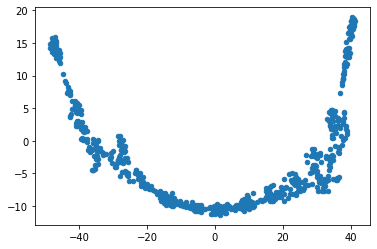

In [1599]:
fig, ax = plt.subplots(1)
mscatter(X_tsne[:, 0], X_tsne[:, 1], s=20, ax=ax)
plt.show()


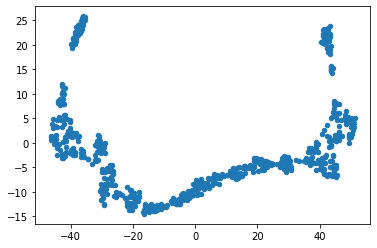

In [1600]:
fig, ax = plt.subplots(1)
mscatter(X_tsne2[:, 0], X_tsne2[:, 1], s=20, ax=ax)
plt.show()

In [1601]:
X_tsne.shape 

(549, 2)

In [1602]:
X_tsne2.shape 

(551, 2)

# Loads HCP csv file and keeps only cognitive parameters

In [1603]:
csv_file = f"{csv_dir}/participants.csv"

In [1604]:
csv = pd.read_csv(csv_file)

In [1605]:
csv.head()

,Subject,Release,Acquisition,Gender,Age,3T_Full_MR_Compl,T1_Count,T2_Count,3T_RS-fMRI_Count,3T_RS-fMRI_PctCompl,...,Noise_Comp,Odor_Unadj,Odor_AgeAdj,PainIntens_RawScore,PainInterf_Tscore,Taste_Unadj,Taste_AgeAdj,Mars_Log_Score,Mars_Errs,Mars_Final
0,100004,S900,Q06,M,22-25,False,0,0,0,0.0,...,5.2,101.12,86.45,2.0,45.9,107.17,105.31,1.80,0.0,1.80
1,100206,S900,Q11,M,26-30,True,1,1,4,100.0,...,6.0,108.79,97.19,1.0,49.7,72.63,72.03,1.84,0.0,1.84
2,100307,Q1,Q01,F,26-30,True,1,1,4,100.0,...,3.6,101.12,86.45,0.0,38.6,71.69,71.76,1.76,0.0,1.76
3,100408,Q3,Q03,M,31-35,True,1,1,4,100.0,...,2.0,108.79,98.04,2.0,52.6,114.01,113.59,1.76,2.0,1.68
4,100610,S900,Q08,M,26-30,True,2,1,4,100.0,...,2.0,122.25,110.45,0.0,38.6,84.84,85.31,1.92,1.0,1.88


In [1606]:
csv = csv[['Subject', 'NEOFAC_A', 'NEOFAC_O', 'NEOFAC_C', 'NEOFAC_N', 'NEOFAC_E']]

## Merge it with hcp_1

In [1607]:
hcp_1.head()

,1,2,3,4
129634,18.790997,16.651400,-0.949327,-2.023810
136833,20.255907,24.995897,-3.304167,-2.089492
206222,20.042776,21.365545,-2.341697,-2.107550
138837,26.757980,-3.610309,16.827570,-1.740514
987983,19.698753,-4.382955,20.739641,-2.156097


In [1608]:
hcp_1.index

Index(['129634', '136833', '206222', '138837', '987983', '562345', '182032',
       '275645', '151021', '177342',
       ...
       '395958', '154734', '385046', '200008', '792867', '618952', '433839',
       '188448', '166640', '541943'],
      dtype='object', length=549)

In [1609]:
csv.Subject = csv.Subject.astype(str).astype(object)

In [1610]:
csv.head()

,Subject,NEOFAC_A,NEOFAC_O,NEOFAC_C,NEOFAC_N,NEOFAC_E
0,100004,27.0,15.0,28.0,24.0,25.0
1,100206,29.0,23.0,26.0,21.0,32.0
2,100307,37.0,24.0,35.0,15.0,37.0
3,100408,33.0,29.0,34.0,15.0,33.0
4,100610,31.0,33.0,36.0,7.0,15.0


In [1611]:
# Checks which subject of hcp_1 is NOT in participants.csv file
hcp_1.index[~hcp_1.index.isin(csv.Subject)]

Index([], dtype='object')

In [1612]:
csv[csv.Subject=='142626']

,Subject,NEOFAC_A,NEOFAC_O,NEOFAC_C,NEOFAC_N,NEOFAC_E


In [1613]:
m_1 = pd.merge(hcp_1, csv, left_on=hcp_1.index, right_on=csv.Subject)

In [1614]:
m_1.head()

,key_0,1,2,3,4,Subject,NEOFAC_A,NEOFAC_O,NEOFAC_C,NEOFAC_N,NEOFAC_E
0,129634,18.790997,16.651400,-0.949327,-2.023810,129634,33.0,26.0,31.0,13.0,34.0
1,136833,20.255907,24.995897,-3.304167,-2.089492,136833,36.0,28.0,33.0,23.0,26.0
2,206222,20.042776,21.365545,-2.341697,-2.107550,206222,23.0,41.0,31.0,25.0,32.0
3,138837,26.757980,-3.610309,16.827570,-1.740514,138837,25.0,30.0,32.0,22.0,28.0
4,987983,19.698753,-4.382955,20.739641,-2.156097,987983,32.0,41.0,32.0,13.0,34.0


In [1615]:
m_1.shape

(549, 11)

In [1616]:
m_1 = m_1.dropna()

In [1617]:
m_1 = m_1.set_index('Subject')
m_1 = m_1.drop('key_0', 1)

In [1618]:
m_1.head()

,1,2,3,4,NEOFAC_A,NEOFAC_O,NEOFAC_C,NEOFAC_N,NEOFAC_E
Subject,,,,,,,,,
129634,18.790997,16.651400,-0.949327,-2.023810,33.0,26.0,31.0,13.0,34.0
136833,20.255907,24.995897,-3.304167,-2.089492,36.0,28.0,33.0,23.0,26.0
206222,20.042776,21.365545,-2.341697,-2.107550,23.0,41.0,31.0,25.0,32.0
138837,26.757980,-3.610309,16.827570,-1.740514,25.0,30.0,32.0,22.0,28.0
987983,19.698753,-4.382955,20.739641,-2.156097,32.0,41.0,32.0,13.0,34.0


In [1619]:
hcp_1.shape

(549, 4)

In [1620]:
m_1.shape

(547, 9)

In [1621]:
X = m_1.iloc[:,0:4].values

In [1622]:
tsne = TSNE(n_components=2, perplexity=30, init='pca', random_state=50)
X_tsne = tsne.fit_transform(X)

In [1623]:
X_tsne.shape

(547, 2)

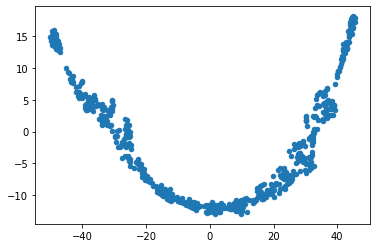

In [1624]:
fig, ax = plt.subplots(1)
mscatter(X_tsne[:, 0], X_tsne[:, 1], s=20, ax=ax)
plt.show()


## Merge it with hcp_2

In [1625]:
# Checks which subject of hcp_1 is NOT in participants.csv file
hcp_2.index[~hcp_2.index.isin(csv.Subject)]

Index([], dtype='object')

In [1626]:
m_2 = pd.merge(hcp_2, csv, left_on=hcp_2.index, right_on=csv.Subject)
m_2.head()

,key_0,1,2,3,4,Subject,NEOFAC_A,NEOFAC_O,NEOFAC_C,NEOFAC_N,NEOFAC_E
0,765864,-1.400854,-10.334003,10.885816,-3.019703,765864,35.0,35.0,26.0,27.0,33.0
1,135124,15.334908,-5.084411,19.804363,-2.380374,135124,38.0,31.0,25.0,26.0,37.0
2,171330,17.115339,29.515924,-4.313017,-2.629971,171330,29.0,41.0,29.0,16.0,31.0
3,158540,21.665155,25.432058,-4.235682,-2.037454,158540,37.0,18.0,39.0,15.0,35.0
4,175338,21.184549,7.049036,3.134527,-1.937242,175338,29.0,36.0,28.0,24.0,32.0


In [1627]:
m_2 = m_2.dropna()

In [1628]:
X2 = m_2.iloc[:,0:4].values
X2.shape

(548, 4)

# Regression with cognitive values

In [1629]:
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score
import seaborn as sns
from pandas.plotting import scatter_matrix

In [1630]:
import statsmodels.api as sm

In [1631]:
m_1_5 = m_1[['NEOFAC_A', 'NEOFAC_O', 'NEOFAC_C', 'NEOFAC_N', 'NEOFAC_E']] 
m_1_5.head()

,NEOFAC_A,NEOFAC_O,NEOFAC_C,NEOFAC_N,NEOFAC_E
Subject,,,,,
129634,33.0,26.0,31.0,13.0,34.0
136833,36.0,28.0,33.0,23.0,26.0
206222,23.0,41.0,31.0,25.0,32.0
138837,25.0,30.0,32.0,22.0,28.0
987983,32.0,41.0,32.0,13.0,34.0


In [1632]:
m_2_5 = m_2[['NEOFAC_A', 'NEOFAC_O', 'NEOFAC_C', 'NEOFAC_N', 'NEOFAC_E']] 
m_2_5.head()

,NEOFAC_A,NEOFAC_O,NEOFAC_C,NEOFAC_N,NEOFAC_E
0,35.0,35.0,26.0,27.0,33.0
1,38.0,31.0,25.0,26.0,37.0
2,29.0,41.0,29.0,16.0,31.0
3,37.0,18.0,39.0,15.0,35.0
4,29.0,36.0,28.0,24.0,32.0


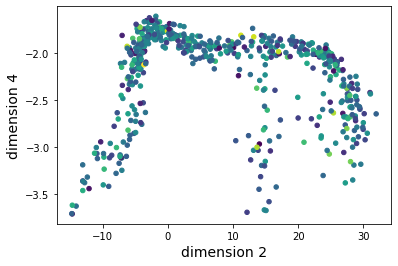

In [1633]:
arr = np.array([np.array([m_1[k][i] for k in m_1.columns[[1,3]]]) for i in range(len(m_1))])

fig, ax = plt.subplots()

mscatter(arr[:, 0], arr[:, 1], c=m_1.NEOFAC_N, s=20, ax=ax)

plt.xlabel(f'dimension 2', fontsize=14)
plt.ylabel(f'dimension 4', fontsize=14)
plt.show()

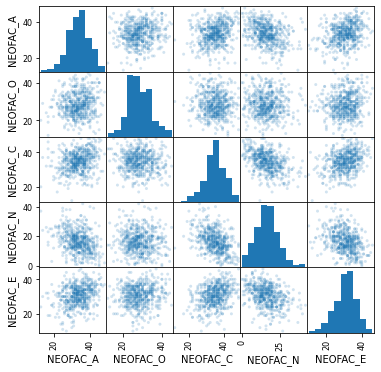

In [1634]:
obj = scatter_matrix(m_1_5, alpha=0.2, figsize=(6, 6), diagonal="hist")

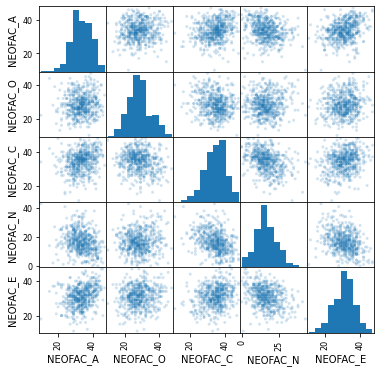

In [1635]:
obj2 = scatter_matrix(m_2_5, alpha=0.2, figsize=(6, 6), diagonal="hist")

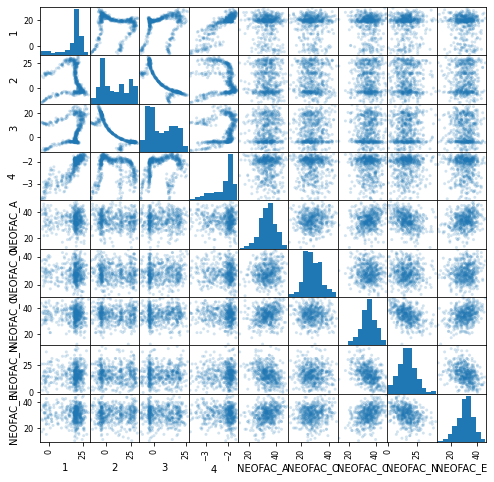

In [1636]:
obj3 = scatter_matrix(m_1, alpha=0.2, figsize=(8, 8), diagonal="hist")

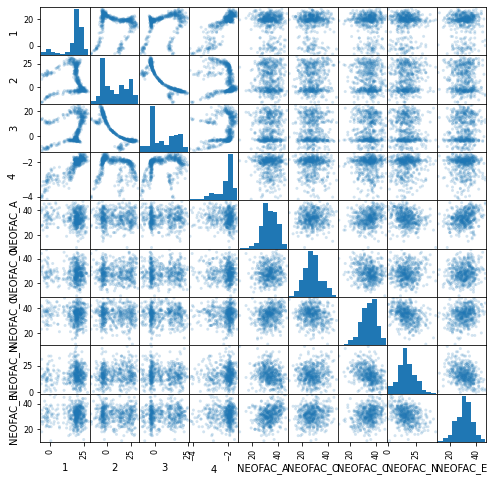

In [1637]:
obj3_2 = scatter_matrix(m_2, alpha=0.2, figsize=(8, 8), diagonal="hist")

In [1638]:
y1_5 = m_1_5.values

In [1639]:
y2_5 = m_2_5.values

In [1640]:
X.shape

(547, 4)

In [1641]:
np.argwhere(np.isnan(y1_5))

array([], shape=(0, 2), dtype=int64)

In [1642]:
m_1.head()

,1,2,3,4,NEOFAC_A,NEOFAC_O,NEOFAC_C,NEOFAC_N,NEOFAC_E
Subject,,,,,,,,,
129634,18.790997,16.651400,-0.949327,-2.023810,33.0,26.0,31.0,13.0,34.0
136833,20.255907,24.995897,-3.304167,-2.089492,36.0,28.0,33.0,23.0,26.0
206222,20.042776,21.365545,-2.341697,-2.107550,23.0,41.0,31.0,25.0,32.0
138837,26.757980,-3.610309,16.827570,-1.740514,25.0,30.0,32.0,22.0,28.0
987983,19.698753,-4.382955,20.739641,-2.156097,32.0,41.0,32.0,13.0,34.0


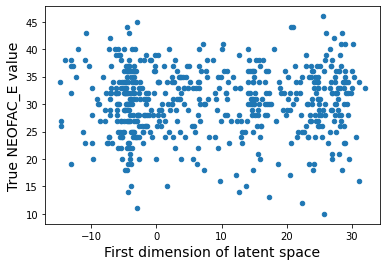

In [1643]:
fig, ax = plt.subplots(1)
mscatter(m_1.iloc[:,1], m_1.NEOFAC_E, s=20, ax=ax)
plt.xlabel(f'First dimension of latent space', fontsize=14)
plt.ylabel(f'True NEOFAC_E value', fontsize=14)
plt.show()

# Multi-output regressor

In [1644]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

In [1645]:
#mregr = MultiOutputRegressor(SVR(kernel='rbf', gamma='auto', C=1.0, epsilon=0.1)).fit(X, y1_5)
#mregr = KNeighborsRegressor(leaf_size=10)
mregr = RandomForestRegressor(max_depth=10, bootstrap=True, n_estimators=10, max_features='auto')

In [1646]:
mregr.fit(X, y1_5)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [1647]:
pred_1_5 = mregr.predict(X)

In [1648]:
pred_1_5.shape

(547, 5)

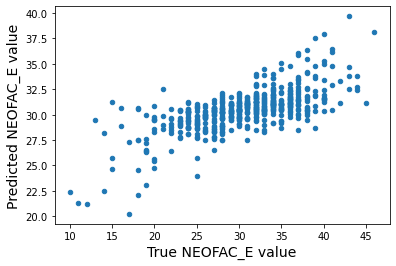

In [1649]:
fig, ax = plt.subplots(1)
mscatter(y1_5[:,4], pred_1_5[:,4], s=20, ax=ax)
plt.xlabel(f'True NEOFAC_E value', fontsize=14)
plt.ylabel(f'Predicted NEOFAC_E value', fontsize=14)
plt.show()

In [1650]:
pred_2_5 = mregr.predict(X2)

In [1651]:
pred_2_5.shape

(548, 5)

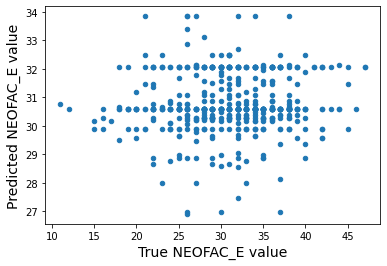

In [1652]:
fig, ax = plt.subplots(1)
mscatter(y2_5[:,4], pred_2_5[:,4], s=20, ax=ax)
plt.xlabel(f'True NEOFAC_E value', fontsize=14)
plt.ylabel(f'Predicted NEOFAC_E value', fontsize=14)
plt.show()

In [1653]:
df_1 = pd.DataFrame(np.concatenate((y1_5,pred_1_5), axis=1))

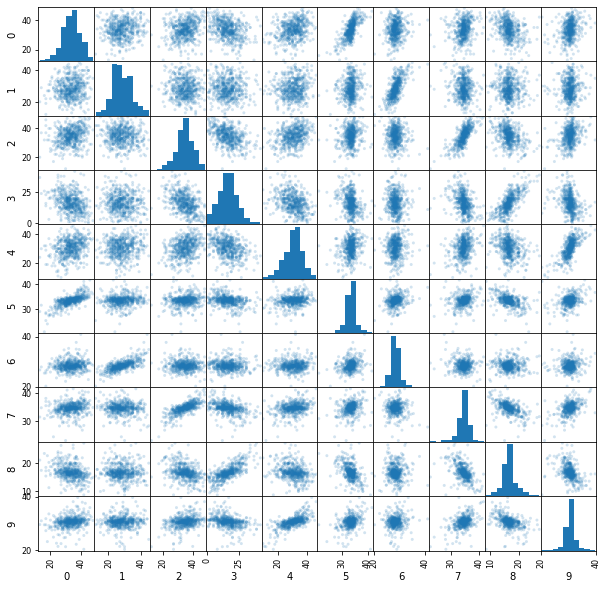

In [1654]:
obj5 = scatter_matrix(df_1, alpha=0.2, figsize=(10, 10), diagonal="hist")

In [1655]:
df_2 = pd.DataFrame(np.concatenate((y2_5,pred_2_5), axis=1))

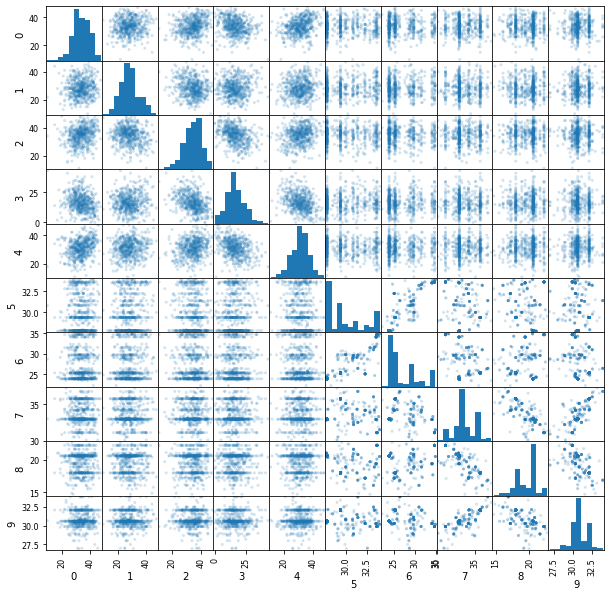

In [1656]:
obj6 = scatter_matrix(df_2, alpha=0.2, figsize=(10, 10), diagonal="hist")

In [1657]:
df_2 = pd.DataFrame(pred_2_5,index=m_2.index)
df_2.head()

,0,1,2,3,4
0,29.400000,25.350000,35.750000,17.960000,32.080000
1,29.400000,25.350000,35.750000,17.960000,32.080000
2,33.507292,34.105729,32.908333,19.363542,30.276042
3,33.507292,31.805729,34.608333,17.263542,32.076042
4,27.845221,23.904412,32.963603,20.563603,30.587132


In [1658]:
df_pred_2 = pd.merge(df_2, m_2_5, left_on=df_2.index, right_on=m_2_5.index)

In [1659]:
df_pred_2 = df_pred_2.drop(columns='key_0')

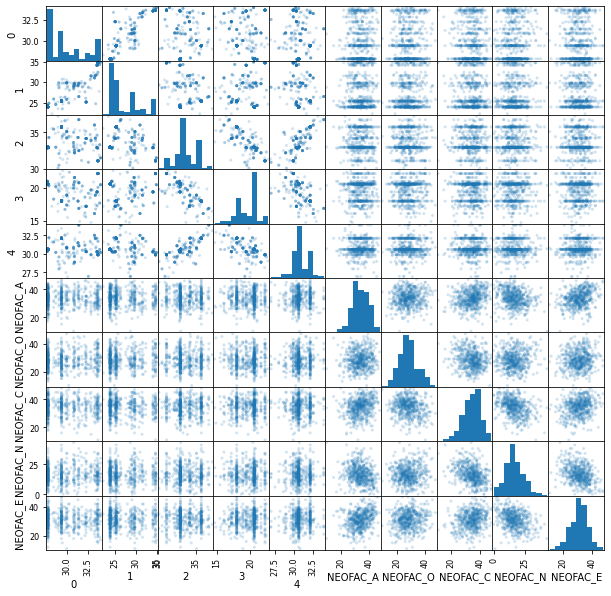

In [1660]:
obj6 = scatter_matrix(df_pred_2, alpha=0.2, figsize=(10, 10), diagonal="hist")

# Regressor Chain

In [1661]:
from sklearn.multioutput import RegressorChain

In [1662]:
#rreg = SVR(kernel='rbf', gamma='auto', C=1.0, epsilon=0.1)
rreg = RandomForestRegressor(max_depth=10)

In [1663]:
chain = RegressorChain(base_estimator=rreg, order=[0,1,2,3,4]).fit(X, y1_5)

In [1664]:
pred_1_5 = chain.predict(X)

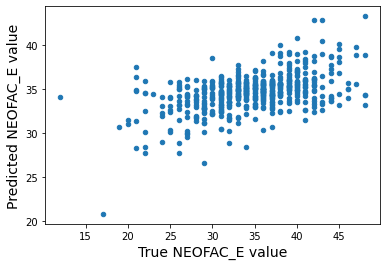

In [1665]:
fig, ax = plt.subplots(1)
mscatter(y1_5[:,2], pred_1_5[:,2], s=20, ax=ax)
plt.xlabel(f'True NEOFAC_E value', fontsize=14)
plt.ylabel(f'Predicted NEOFAC_E value', fontsize=14)
plt.show()

In [1666]:
pred_2_5 = mregr.predict(X2)

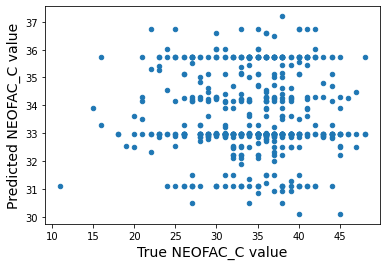

In [1667]:
fig, ax = plt.subplots(1)
mscatter(y2_5[:,2], pred_2_5[:,2], s=20, ax=ax)
plt.xlabel(f'True NEOFAC_C value', fontsize=14)
plt.ylabel(f'Predicted NEOFAC_C value', fontsize=14)
plt.show()

In [1668]:
df_1 = pd.DataFrame(np.concatenate((y1_5,pred_1_5), axis=1))

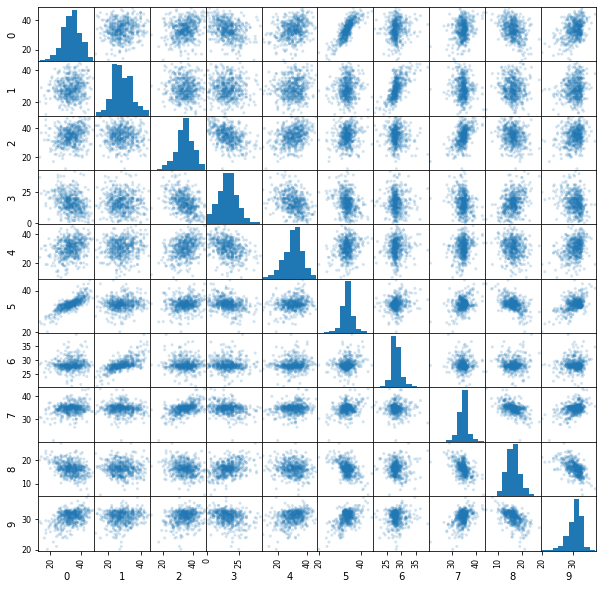

In [1669]:
obj8 = scatter_matrix(df_1, alpha=0.2, figsize=(10, 10), diagonal="hist")

In [1670]:
df_2 = pd.DataFrame(np.concatenate((y2_5,pred_2_5), axis=1))

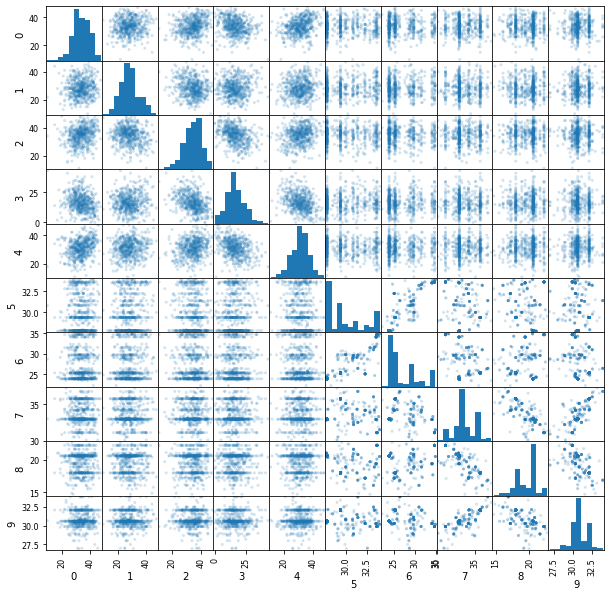

In [1671]:
obj9 = scatter_matrix(df_2, alpha=0.2, figsize=(10, 10), diagonal="hist")

# We use here standards models with ordinary least squares

In [1672]:
y1_5.shape

(547, 5)

In [1673]:
yC_1_5 = y1_5[:,2]

In [1674]:
yC_2_5 = y2_5[:,2]

In [1675]:
est = sm.OLS(yC_1_5, X)
est2 = est.fit()
print(est2.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.971
Model:                            OLS   Adj. R-squared (uncentered):              0.971
Method:                 Least Squares   F-statistic:                              4542.
Date:                Mon, 28 Mar 2022   Prob (F-statistic):                        0.00
Time:                        16:17:08   Log-Likelihood:                         -1754.0
No. Observations:                 547   AIC:                                      3516.
Df Residuals:                     543   BIC:                                      3533.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

We now use the SVR from scikit-learn

In [1676]:
regr = make_pipeline(SVR(kernel='rbf', gamma='auto', C=1.0, epsilon=0.1))

In [1677]:
X.shape

(547, 4)

In [1678]:
regr.fit(X, yC_1_5)
pred_C = regr.predict(X)
regr.score(X, yC_1_5)

0.12320063320720565

In [1679]:
pred_C2 = regr.predict(X2)
regr.score(X2, yC_2_5)

-0.006838204836714601

In [1680]:
pred_C2

array([34.84473128, 34.84473128, 34.84473128, 34.84473128, 34.84473128,
       34.84473128, 34.84473128, 34.84473128, 34.84473128, 34.84473128,
       34.84473128, 34.84473128, 34.84473128, 34.84473128, 34.84473128,
       34.84473128, 34.84473128, 34.84473128, 34.84473128, 34.84473128,
       34.84473128, 34.84473128, 34.84473128, 34.84473128, 34.84473128,
       34.84473128, 34.84473128, 34.84473128, 34.84473128, 34.84473128,
       34.84473128, 34.84473128, 34.84473128, 34.84473128, 34.84473128,
       34.84473128, 34.84473128, 34.84473128, 34.84473128, 34.84473128,
       34.84473128, 34.84473128, 34.84473128, 34.84473128, 34.84473128,
       34.84473128, 34.84473128, 34.84473128, 34.84473128, 34.84473128,
       34.84473128, 34.84473128, 34.84473128, 34.84473128, 34.84473128,
       34.84473128, 34.84473128, 34.84473128, 34.84473128, 34.84473128,
       34.84473128, 34.84473128, 34.84473128, 34.84473128, 34.84473128,
       34.84473128, 34.84473128, 34.84473128, 34.84473128, 34.84

In [1681]:
explained_variance_score(yC_1_5, pred_C)

0.12495333270619802

In [1682]:
r2_score(yC_1_5, pred_C)

0.12320063320720565

In [1683]:
est = sm.OLS(pred_C, yC_1_5)
est2 = est.fit()
print(est2.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.977
Model:                            OLS   Adj. R-squared (uncentered):              0.977
Method:                 Least Squares   F-statistic:                          2.296e+04
Date:                Mon, 28 Mar 2022   Prob (F-statistic):                        0.00
Time:                        16:17:08   Log-Likelihood:                         -1689.8
No. Observations:                 547   AIC:                                      3382.
Df Residuals:                     546   BIC:                                      3386.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [1684]:
est2.conf_int(alpha=0.05, cols=None)

array([[0.96961491, 0.9950845 ]])

In [1685]:
regr_lin = linear_model.LinearRegression()
regr_lin.fit(yC_1_5.reshape(-1, 1), pred_C)
lin_C = regr_lin.predict(yC_1_5.reshape(-1, 1))

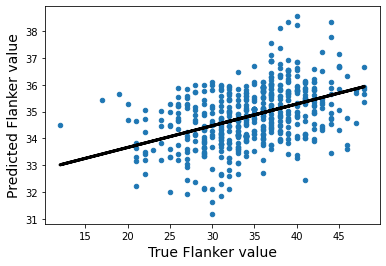

In [1686]:
fig, ax = plt.subplots(1)
mscatter(yC_1_5, pred_C, s=20, ax=ax)
plt.plot(yC_1_5, lin_C, color="black", linewidth=3)
plt.xlabel(f'True Flanker value', fontsize=14)
plt.ylabel(f'Predicted Flanker value', fontsize=14)
plt.show()

In [1687]:
data = sns.load_dataset("tips")
data.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


<AxesSubplot:>

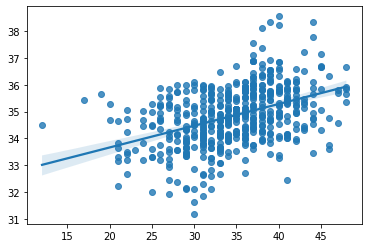

In [1688]:
sns.regplot(x=yC_1_5, y=pred_C)

In [1689]:
pred_C2

array([34.84473128, 34.84473128, 34.84473128, 34.84473128, 34.84473128,
       34.84473128, 34.84473128, 34.84473128, 34.84473128, 34.84473128,
       34.84473128, 34.84473128, 34.84473128, 34.84473128, 34.84473128,
       34.84473128, 34.84473128, 34.84473128, 34.84473128, 34.84473128,
       34.84473128, 34.84473128, 34.84473128, 34.84473128, 34.84473128,
       34.84473128, 34.84473128, 34.84473128, 34.84473128, 34.84473128,
       34.84473128, 34.84473128, 34.84473128, 34.84473128, 34.84473128,
       34.84473128, 34.84473128, 34.84473128, 34.84473128, 34.84473128,
       34.84473128, 34.84473128, 34.84473128, 34.84473128, 34.84473128,
       34.84473128, 34.84473128, 34.84473128, 34.84473128, 34.84473128,
       34.84473128, 34.84473128, 34.84473128, 34.84473128, 34.84473128,
       34.84473128, 34.84473128, 34.84473128, 34.84473128, 34.84473128,
       34.84473128, 34.84473128, 34.84473128, 34.84473128, 34.84473128,
       34.84473128, 34.84473128, 34.84473128, 34.84473128, 34.84

<AxesSubplot:>

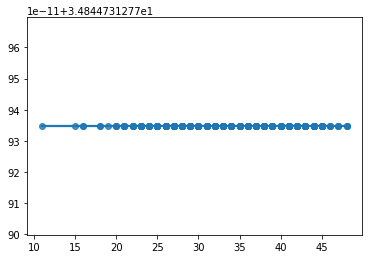

In [1690]:
sns.regplot(x=yC_2_5, y=pred_C2)

In [1691]:
print(subject_labels[-4:-1])
print(m_1.index[-4:-1])

['433839' '188448' '166640']
Index(['433839', '188448', '166640'], dtype='object', name='Subject')


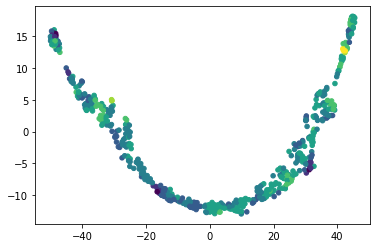

In [1692]:
fig, ax = plt.subplots(1)
mscatter(X_tsne[:, 0], X_tsne[:, 1], c=pred_C.astype(int), s=20, ax=ax)
plt.show()

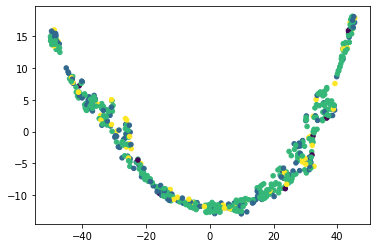

In [1693]:
fig, ax = plt.subplots(1)
mscatter(X_tsne[:, 0], X_tsne[:, 1], c=((yC_1_5-12)/10).astype(int), s=20, ax=ax)
plt.show()

In [1694]:
yC_1_5.mean()

34.60694698354662

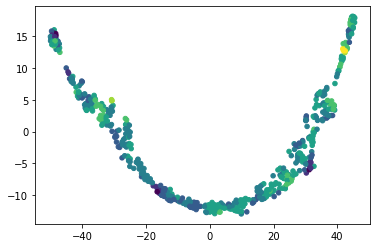

In [1695]:
fig, ax = plt.subplots(1)
mscatter(X_tsne[:, 0], X_tsne[:, 1], c=pred_C.astype(int), s=20, ax=ax)
plt.show()

In [1696]:
yC_1_5_class = ((yC_1_5-12)/7).astype(int)
print(np.unique(yC_1_5))
print(np.unique(yC_1_5_class))

[12. 17. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34.
 35. 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48.]
[0 1 2 3 4 5]


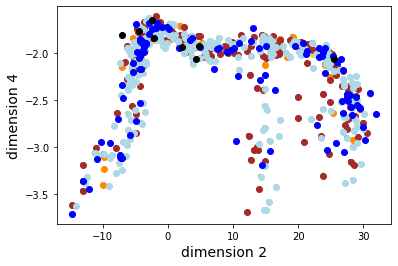

In [1697]:
arr = np.array([np.array([m_1[k][i] for k in m_1.columns[[1,3]]]) for i in range(len(m_1))])

fig, ax = plt.subplots()

color_dict = {0: 'gold', 1:'darkorange', 2:'brown', 3:'lightblue', 4:'blue', 5:'black'}

mscatter(arr[:, 0], arr[:, 1], c=((yC_1_5-70)/10).astype(int), s=20, ax=ax)

for g in np.unique(yC_1_5_class):
    ix = np.where(yC_1_5_class == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    ax.scatter(x, y, c = color_dict[g])

plt.xlabel(f'dimension 2', fontsize=14)
plt.ylabel(f'dimension 4', fontsize=14)
plt.show()

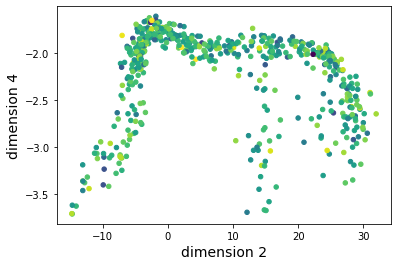

In [1698]:
arr = np.array([np.array([m_1[k][i] for k in m_1.columns[[1,3]]]) for i in range(len(m_1))])

fig, ax = plt.subplots()

mscatter(arr[:, 0], arr[:, 1], c=yC_1_5, s=20, ax=ax)

plt.xlabel(f'dimension 2', fontsize=14)
plt.ylabel(f'dimension 4', fontsize=14)
plt.show()

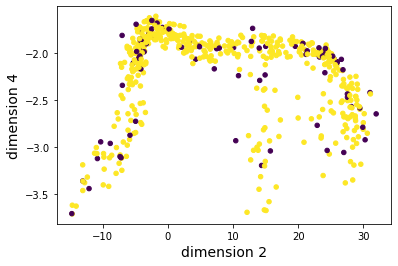

In [1699]:
arr = np.array([np.array([m_1[k][i] for k in m_1.columns[[1,3]]]) for i in range(len(m_1))])

fig, ax = plt.subplots()

mscatter(arr[:, 0], arr[:, 1], c=~((yC_1_5.astype(int)<50) & (yC_1_5.astype(int)>40)), s=20, ax=ax)

plt.xlabel(f'dimension 2', fontsize=14)
plt.ylabel(f'dimension 4', fontsize=14)
plt.show()

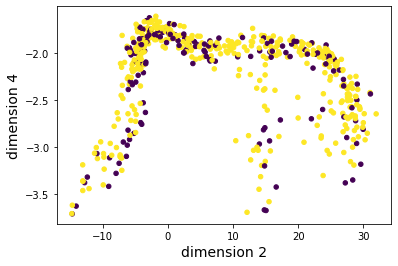

In [1700]:
arr = np.array([np.array([m_1[k][i] for k in m_1.columns[[1,3]]]) for i in range(len(m_1))])

fig, ax = plt.subplots()

mscatter(arr[:, 0], arr[:, 1], c=~((yC_1_5.astype(int)<40) & (yC_1_5.astype(int)>35)), s=20, ax=ax)

plt.xlabel(f'dimension 2', fontsize=14)
plt.ylabel(f'dimension 4', fontsize=14)
plt.show()

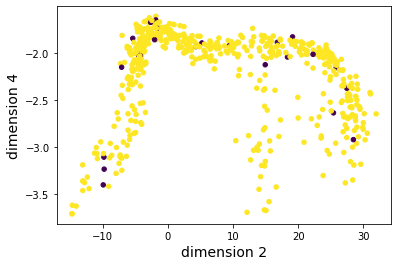

In [1701]:
arr = np.array([np.array([m_1[k][i] for k in m_1.columns[[1,3]]]) for i in range(len(m_1))])

fig, ax = plt.subplots()

mscatter(arr[:, 0], arr[:, 1], c=~((yC_1_5.astype(int)<25) & (yC_1_5.astype(int)>11)), s=20, ax=ax)

plt.xlabel(f'dimension 2', fontsize=14)
plt.ylabel(f'dimension 4', fontsize=14)
plt.show()

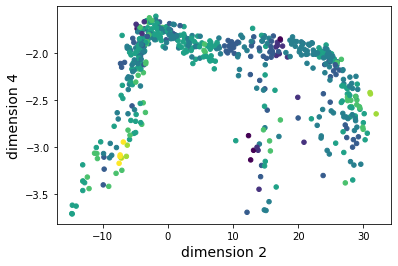

In [1702]:
arr = np.array([np.array([m_1[k][i] for k in m_1.columns[[1,3]]]) for i in range(len(m_1))])

fig, ax = plt.subplots()

mscatter(arr[:, 0], arr[:, 1], c=pred_C.astype(int), s=20, ax=ax)

plt.xlabel(f'dimension 2', fontsize=14)
plt.ylabel(f'dimension 4', fontsize=14)
plt.show()

## Define it as a multiclass proba

In [1703]:
from sklearn import svm
from sklearn.model_selection import cross_val_score

In [1704]:
y_high = (yC_1_5>40).astype(int)
np.unique(y_high, return_counts=True)

(array([0, 1]), array([467,  80]))

In [1705]:
clf_c = make_pipeline(StandardScaler(), svm.SVC(C=1, class_weight='balanced', probability=True))

In [1706]:
scores = cross_val_score(clf_c, X, y_high, cv=5)
print(scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

[0.45454545 0.45454545 0.62385321 0.46788991 0.62385321]
0.52 accuracy with a standard deviation of 0.08


In [1707]:
y_high[0:3]

array([0, 0, 0])

In [1708]:
clf_c = make_pipeline(StandardScaler(), svm.SVC(C=1, class_weight='balanced', probability=True))

In [1709]:
y_high_proba = clf_c.fit(X, y_high).predict_proba(X)
y_high_proba[:3,0]

array([0.85047591, 0.8720083 , 0.86310231])

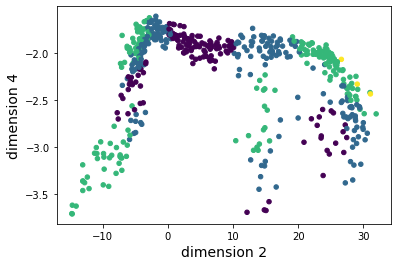

In [1710]:
arr = np.array([np.array([m_1[k][i] for k in m_1.columns[[1,3]]]) for i in range(len(m_1))])

fig, ax = plt.subplots()

mscatter(arr[:, 0], arr[:, 1], c=(y_high_proba[:,0]*50).astype(int), s=20, ax=ax)

plt.xlabel(f'dimension 2', fontsize=14)
plt.ylabel(f'dimension 4', fontsize=14)
plt.show()

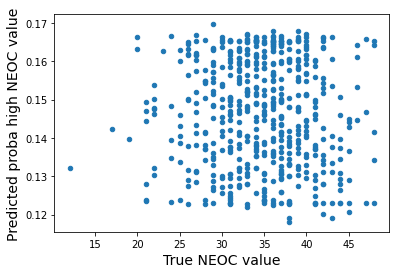

In [1711]:
fig, ax = plt.subplots(1)
mscatter(yC_1_5, y_high_proba[:,1], s=20, ax=ax)
plt.xlabel(f'True NEOC value', fontsize=14)
plt.ylabel(f'Predicted proba high NEOC value', fontsize=14)
plt.show()